# Import basic libraries

Let's import some basic stuff

## TODO
- Add the nodes in the CityJSON file, keeping the relationships between nodes and edges (linestrings). The nodes have semantics and atttributes.
- Find a small area and compute widths.
- Create LoD0.1 with single lines and attributes for two-way and same for LoD0.2.

# Ideas for modelling

1. Every city object contains `MultiPoints` (nodes of LoD0.1), `MultiLineStrings` (edges of LoD0.1) and `MultiSurfaces `(for LoD1+).
2. Every city object contains `MultiLineStrings` (geometry of edges of LoD0.1) and `MultiSurfaces` (for LoD1+). The network topology (nodes and edges) is defined in its own `"+network"` portion of the city model.
3. Every city object has its own `MultiSurfaces` (for LoD1+). Then the actual network (nodes, edges and their geometry) is stored in `"+network"`.
4. Every node is its own city object. Every edge is its own city object. Every surface is its own city object. Then `CityObjectGroups` are used to relate them.

### Fix for `fiona`

*`fiona` has an issue with GDAL 3.0. Better set your `GDAL_DATA` path to fiona's installation (contains GDAL 2.4.4) prior to running this script.*

In [1]:
import geopandas
import pandas as pd
import osmnx as ox
import networkx as nx
import shapely

# Load the OSM data

This will load the osm file to a network

In [ ]:
# We don't want edges to be loaded twice
ox.config(all_oneway=True)

network_graph = ox.graph_from_file('../data/Breda/Breda extract.osm', simplify=False)
# We simplify the graph afterwards, so that osmids are not "smashed" together
network_graph = ox.simplify_graph(network_graph, strict=False)

We create `UUID` for every edge:

In [123]:
import uuid
import hashlib
import json
from cityhash import CityHash32

hashes = []
for u,v,a in network_graph.edges(data=True):
    temp = {
        "osmid": a['osmid'],
        "length": a['length']
    }
    a['uuid'] = CityHash32(uuid.uuid4().hex)
    hashes.append(a['uuid'])

assert len(hashes) == len(set(hashes))

Then we export the edges to a GeoDataFrame:

In [124]:
edges = ox.graph_to_gdfs(network_graph, nodes=False, node_geometry=False)

edges = edges.to_crs("EPSG:28992")

len(edges)

9856

In [125]:
edges.head()

,u,v,key,osmid,highway,name,area,length,uuid,geometry,oneway,maxspeed,landuse,bridge,access,tunnel,service,lanes,ref,width
0,689995792,689990659,0,126559191,pedestrian,Havermarkt,yes,5.549,354005527,"LINESTRING (112471.505 400203.536, 112466.591 ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,689995792,2731861671,0,267778236,NaN,NaN,NaN,5.977,521711627,"LINESTRING (112471.505 400203.536, 112477.359 ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,689995792,2731859065,0,267783561,NaN,NaN,NaN,14.574,2319193831,"LINESTRING (112471.505 400203.536, 112472.478 ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2731868250,2731868295,0,267781406,NaN,NaN,NaN,3.006,2871823943,"LINESTRING (113052.271 400255.385, 113049.979 ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2731868250,2731867934,0,267778466,NaN,NaN,NaN,1.691,4159467448,"LINESTRING (113052.271 400255.385, 113051.633 ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
n, e = ox.graph_to_gdfs(network_graph)

## Play with the graph data
Those a little experimentation for me (nothing useful here).

In [6]:
# As per https://gis.stackexchange.com/a/184535

# evaluate on connected components
connected_components = [network_graph.subgraph(c) for c in nx.weakly_connected_components(network_graph)]

# gather edges and components to which they belong
fid_comp = {}
for i, graph in enumerate(connected_components):
    for edge in graph.edges(data=True):
        fid_comp[edge[2].get('fid', None)] = i

In [7]:
# ec = ['r' if data['oneway'] else 'b' for u, v, key, data in network_graph.edges(keys=True, data=True)]
# ox.plot_graph(network_graph, file_format='svg', save=True, filename='ways', fig_height=15, edge_color=ec)

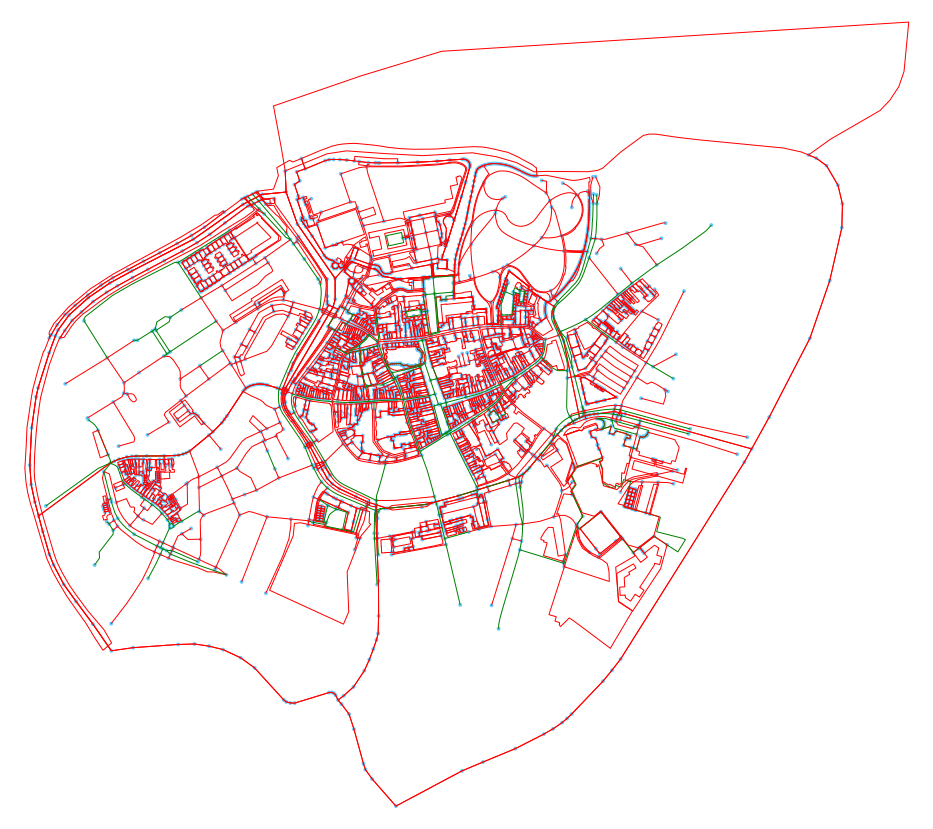

(<Figure size 1959.53x1080 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11fdfc0d0>)

In [8]:
ec = ['g' if 'maxspeed' in data or ('highway' in data and data['highway'] == 'pedestrian') else 'r' for u, v, key, data in network_graph.edges(keys=True, data=True)]
ox.plot_graph(network_graph, fig_height=15, edge_color=ec)

In [9]:
# from keys import google_elevation_api_key

## Filter drive and service roads only

Filter roads to only motorways:

In [126]:
highway_types = [
    "primary",
    "secondary",
    "motorway",
    "trunk",
    "tertiary",
    "unclassified",
    "residential",

    "motorway_link",
    "trunk_link",
    "primary_link",
    "secondary_link",
    "tertiary_link",

    "living_street",
    "service",
    "pedestrian",
    "track",
    "bus_guideway",
    "escape",
    "raceway",
    "road"
]

road_edges = edges[(edges['highway'].isin(highway_types)) & (edges['area'] != 'yes')]

road_edges.to_file('output/road_edges.geojson', driver='GeoJSON')
len(road_edges)

685

In [127]:
road_edges.head()

,u,v,key,osmid,highway,name,area,length,uuid,geometry,oneway,maxspeed,landuse,bridge,access,tunnel,service,lanes,ref,width
52,6450151604,43136448,0,7224397,tertiary,Keizerstraat,NaN,10.281,2450698191,"LINESTRING (112852.058 399899.616, 112851.205 ...",yes,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
94,43155685,4454022829,0,7225340,service,NaN,NaN,8.436,1031288535,"LINESTRING (112517.886 400392.439, 112520.296 ...",NaN,NaN,NaN,yes,no,NaN,NaN,NaN,NaN,NaN
99,1642954984,2197761851,0,7224390,tertiary,Kloosterplein,NaN,5.654,3714148847,"LINESTRING (112993.855 400056.230, 112999.227 ...",yes,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101,1642954984,43142237,0,7224394,tertiary,Vlaszak,NaN,8.249,1226011887,"LINESTRING (112993.855 400056.230, 112994.962 ...",yes,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
125,1401651638,2731824407,0,126447044,pedestrian,Sint Janstraat,NaN,7.449,3877654871,"LINESTRING (112787.440 400066.830, 112783.461 ...",NaN,NaN,NaN,NaN,NaN,yes,NaN,NaN,NaN,NaN


# Load the BGT data

In [11]:
bgt_roads = geopandas.read_file('../data/Breda/bgt_roads.geojson')

len(bgt_roads)

38859

## Compute primary-secondary road polygons

We need to assign secondary road polygons (parking spaces, sidewalks) to the primary roads

### Filter primary roads

Primary types are those that vehicles are supposed to move:

In [12]:
bgt_road_types = [
    'rijbaan lokale weg',
    'rijbaan regionale weg',
    # 'overweg' # Maybe?
]

bgt_roads =  bgt_roads[bgt_roads['eindRegistratie'].isnull()]

bgt_roads['parent_gml_id'] = bgt_roads['gml_id']

bgt_main_roads = bgt_roads[bgt_roads['function'].isin(bgt_road_types)]

len(bgt_main_roads)

6899

### Identify parent for every secondary road

Find the secondary roads that touch the main ones:

In [13]:
bgt_secondary_roads = bgt_roads[~bgt_roads['function'].isin(bgt_road_types)]

len(bgt_secondary_roads)

19551

#### Old way
**TODO:** We need to improve the way that main road is assigned (get the one with the highest shared boundary, not just a random one)

In [14]:
# joined = geopandas.sjoin(bgt_secondary_roads, bgt_main_roads, how='left', op='intersects')

# joined = joined[['gml_id_left', 'function_left', 'gml_id_right', 'geometry']]
# joined.columns = ['gml_id', 'function', 'parent_gml_id', 'geometry']

# bgt_roads_parented = geopandas.GeoDataFrame(joined.groupby('gml_id').aggregate('first').reset_index(), crs='EPSG:28992')

# len(bgt_roads_parented)

#### New way
Let's overlay the secondary roads with the main roads. The result should be (mostly) linestrings accross their common boundaries:

In [15]:
bgt_common_boundaries = geopandas.overlay(bgt_secondary_roads, bgt_main_roads, how='intersection', keep_geom_type=False)

len(bgt_common_boundaries)

29544

We need to compute the longest common boundary per `gml_id` to pick the respective parent `gml_id`:

In [16]:
bgt_common_boundaries['length'] = bgt_common_boundaries['geometry'].length

max_rows = bgt_common_boundaries[['gml_id_1', 'function_1', 'gml_id_2', 'geometry', 'length']].groupby('gml_id_1')['length'].idxmax()

Now, let's join this with the original secondary rows table to bring back their original geometries:

In [17]:
temp_roads = bgt_common_boundaries.loc[max_rows]
temp_roads = temp_roads[['gml_id_1', 'function_1', 'gml_id_2', 'geometry']]
temp_roads = temp_roads.rename(columns={'gml_id_1': 'gml_id', 'function_1': 'function', 'gml_id_2': 'parent_gml_id'})
temp_roads = temp_roads.set_index('gml_id')

bgt_roads_parented = temp_roads.merge(bgt_secondary_roads.set_index('gml_id'), on='gml_id', suffixes=('', '_right'))
bgt_roads_parented = bgt_roads_parented[['function', 'parent_gml_id', 'geometry_right']].rename(columns={'geometry_right': 'geometry'})
bgt_roads_parented = bgt_roads_parented.reset_index()

bgt_roads_parented = geopandas.GeoDataFrame(bgt_roads_parented, crs='EPSG:28992')

len(bgt_roads_parented)

14235

### Merge primary and secondary roads

Concatenate everything:

In [18]:
bgt_all_roads = pd.concat([bgt_roads_parented, bgt_main_roads[['gml_id', 'function', 'parent_gml_id', 'geometry']]])

bgt_all_roads.to_file('output/bgt_all_roads.geojson', driver='GeoJSON')

len(bgt_all_roads)

21134

# Intersect roads network with polygon
First, we intersect the road lines with the BGT polygons (to create nodes at the polygon boundaries):

In [19]:
roads = geopandas.overlay(road_edges, bgt_all_roads, how='intersection')

Export the intersected roads to `GeoJSON`:

In [20]:
roads.to_file('output/roads.json', driver='GeoJSON')

roads.head()

,u,v,key,osmid,highway,name,area,length,oneway,maxspeed,...,access,tunnel,service,lanes,ref,width,gml_id,function,parent_gml_id,geometry
0,6450151604,43136448,0,7224397,tertiary,Keizerstraat,NaN,10.281,yes,50,...,NaN,NaN,NaN,NaN,NaN,NaN,b7242fa64-c535-4445-be1c-7bfbe7f9564f,fietspad,bebfd7ae6-7fd0-4d2a-b300-ba3b13525b4d,"LINESTRING (112850.872 399908.820, 112850.743 ..."
1,43136448,43136804,0,7224397,tertiary,Keizerstraat,NaN,13.041,yes,50,...,NaN,NaN,NaN,NaN,NaN,NaN,b7242fa64-c535-4445-be1c-7bfbe7f9564f,fietspad,bebfd7ae6-7fd0-4d2a-b300-ba3b13525b4d,"LINESTRING (112850.743 399909.818, 112850.605 ..."
2,6450151604,43136448,0,7224397,tertiary,Keizerstraat,NaN,10.281,yes,50,...,NaN,NaN,NaN,NaN,NaN,NaN,b1f4910c2-00c3-4fce-856a-847a5e337f16,rijbaan lokale weg,b1f4910c2-00c3-4fce-856a-847a5e337f16,"LINESTRING (112852.058 399899.616, 112851.205 ..."
3,43132022,6450151604,0,7224415,tertiary,Keizerstraat,NaN,82.845,yes,50,...,NaN,NaN,NaN,NaN,NaN,NaN,b1f4910c2-00c3-4fce-856a-847a5e337f16,rijbaan lokale weg,b1f4910c2-00c3-4fce-856a-847a5e337f16,"LINESTRING (112857.519 399822.959, 112858.531 ..."
4,43155685,4454022829,0,7225340,service,NaN,NaN,8.436,NaN,NaN,...,no,NaN,NaN,NaN,NaN,NaN,b7bfd8ed3-cf75-40ac-9af4-7b06596a7879,rijbaan lokale weg,b7bfd8ed3-cf75-40ac-9af4-7b06596a7879,"LINESTRING (112517.886 400392.439, 112520.230 ..."


# Export to CityJSON

Let's export everything to CityJSON.

First, we'll define how the established intersected lines will be translated to `Road` objects:

In [21]:
def process_ring(line, vertices):
    """Returns the boundaries array of a single linear rings.
    
    Arguments:
    line -- The LineString to be processed (represents the ring)
    vertices -- the global vertices list of the CityJSON
    """
    points = [[x, y, 0] for x, y in list(line.coords)]
    indices = [i + len(vertices) for i in range(len(points))]
    for p in points:
        vertices.append(p)

    return indices

def process_linestring(geom, vertices):
    """Returns the boundaries array of a linear element.
    
    This can process LineString or MultiLineString geometries.
    
    Arguments:
    geom -- the (linear) geometry to be processed
    vertices -- the global vertices list of the CityJSON
    """
    if geom.type == "LineString":
        indices = [process_ring(geom, vertices)]
    else:
        indices = []
        
        for l in geom.geoms:
            indices.append(process_ring(l, vertices))
        
    return indices

def create_geometry(geom, lod, vertices):
    """Returns a CityJSON geometry from a single shapely geometry.
    
    This will also append the 'vertices' list with new vertices.
    
    Arguments:
    geom -- the shapely geometry to be processed
    lod -- the lod of the resulting CityJSON geometry
    vertices -- the global vertices list of the CityJSON
    """
    indices = []
    
    if geom.type == "LineString" or geom.type == "MultiLineString":
        geom_type = "MultiLineString"
        
        indices = process_linestring(geom, vertices)
    elif geom.type == "Polygon":
        geom_type = "MultiSurface"
        
        indices = [process_linestring(geom.boundary, vertices)]
    else:
        raise TypeError(geom.type)
    
    return {
        "type": geom_type,
        "lod": lod,
        "boundaries": indices
    }

def create_geom_with_semantics(map_func, features, lod, vertices, geom_column='geometry'):
    """Returns a CityJSON geometry with semantic elements from multiple features.
    
    Semantic elements are semantic lines (for LineString) or surfaces (for
    MultiSurface).
    
    Arguments:
    map_func -- function that maps an input feature to an output semantic element
    features -- list of features to be processed
    lod -- the lod of the resulting CityJSON geometry
    vertices -- the global vertices list of the CityJSON
    """
    boundaries = []
    semantics = {
        "surfaces": [],
        "values": []
    }
    
    # Get the resulting geometry type from the first feature
    geom = features[0][geom_column]
    if geom.type == "LineString" or geom.type == "MultiLineString":
        geom_type = "MultiLineString"
    elif geom.type == "Polygon":
        geom_type = "MultiSurface"
    else:
        raise TypeError(geom.type)
    
    # Process all features
    i = 0
    for f in features:
        surface = map_func(f)
        
        if geom_type == "MultiLineString":
            indices = process_linestring(f[geom_column], vertices)
            for l in indices:
                boundaries.append(l)
                semantics["surfaces"].append(surface)
                semantics["values"].append(i)
                i = i + 1
        else:
            indices = process_linestring(f[geom_column].boundary, vertices)
        
            boundaries.append(indices)
            semantics["surfaces"].append(surface)
            semantics["values"].append(i)
            i = i + 1
    
    return {
        "type": geom_type,
        "lod": lod,
        "boundaries": boundaries,
        "semantics": semantics
    }

def osm_semantics_map(feature):
    obj = {
        "type": feature['highway'],
        "osm_id": feature['osmid'],
        "oneway": feature['oneway'] if isinstance(feature['oneway'], str) else "no"
    }
    
    if isinstance(feature['name'], str):
        obj["name"] = feature['name']
    
    if isinstance(feature['maxspeed'], str):
        obj["maxspeed"] = feature['maxspeed']
    
    return obj

def bgt_semantics_map(feature):
    return {
        "type": feature['function'],
        "gml_id": feature['gml_id']
    }

def create_cityobject(feature, vertices):
    """Create a CityJSON city object from a single OSM linear features."""
    return {
        "type": "Road",
        "attributes": {
            "osm_id": feature['osmid'],
            "highway": feature['highway'],
        },
        "geometry": [
            create_geometry(feature['geometry'], "0.1", vertices)
        ]
    }

Now, let's run this against all intersected road segments:

In [22]:
vertices = []
objects = {}

road_groups = roads.groupby('parent_gml_id')

for gml_id, group in road_groups:
    features = [f for i, f in group.iterrows()]
    objects[gml_id] = {
        "type": "Road",
        "geometry": [
            create_geom_with_semantics(osm_semantics_map,
                                       features,
                                       '0.1',
                                       vertices)
        ]
    }

bgt_roads_groups = bgt_all_roads.groupby('parent_gml_id')

for main_gml_id, group in bgt_roads_groups:
    if main_gml_id in objects:
        features = [f for i, f in group.iterrows()]
        objects[main_gml_id]['geometry'].append(
            create_geom_with_semantics(bgt_semantics_map,
                                       features,
                                       '2',
                                       vertices)
        )

Finally, let's export everything as CityJSON:

In [23]:
import json
import io

output = {
  "type": "CityJSON",
  "version": "1.0",
  "CityObjects": objects,
  "vertices": vertices
}

with open('output/breda.json', 'w') as file:
    json.dump(output, file)

## Fix missing network and polygons
We should create individual road objects for the polygons (and respective network segments) that do not have a `parent_gml_id`.

# Calculate carriageways and lanes
- Compute the carriageways only from OSM attributes.
- Compute road width:
     - We exclude intersections.
- How we create the carriageways for twoway streets and more specifically for intersections.

NOTE: Case of a two-way road where we figure out that the road width doesn't fit two lanes (special case were two ways share the same carriageway).

## Create perpendicular lines

In [177]:
from shapely.ops import unary_union
from shapely.geometry import Point, LineString, MultiLineString

offset = 100

def get_vertex(line, first=True):
    """Returns the first or last vertex"""
    if line.type == "LineString":
#         print(len(line.boundary))
        return line.boundary[0 if first else len(line.boundary) - 1]
    elif line.type == "MultiLineString" and len(line.geoms) == 1:
        return line.geoms[0].boundary[0 if first else len(line.boundary) - 1]
    else:
        raise TypeError("This is MultiLineString with many parts!")
    

def get_perpendicular_line(geom):
    if geom.type == 'LineString':
        left = geom.parallel_offset(offset, 'left')
        right = geom.parallel_offset(offset, 'right')
        if left.length == 0 or right.length == 0:
            print(geom.wkt)
        a = get_vertex(left, False)
        b = get_vertex(right, True)
        return LineString([a, b])
    else:
        lines = []
        for line in geom.geoms:
            lines.append(get_perpendicular_line(line))
        
        return unary_union(lines)

roads['perp_line'] = roads['geometry'].apply(get_perpendicular_line)

LINESTRING (112605.4405657589 400399.0009858242, 112568.7387348649 400391.5769331097, 112563.073821821 400420.0730858373)


IndexError: tuple index out of range

In [ ]:
roads['geometry'].plot()

## Calculate width
Let's join the network lines with the polygons:

In [ ]:
common = roads.set_index('parent_gml_id').merge(bgt_all_roads.set_index('gml_id'), on='gml_id', suffixes=('', '_right'))

common.columns

### 1. Old (and slow) way:
We can compute the road width by computing perpendicular lines at one end of the network line and intersecting that with the polygon of the road. This is unreliable and slow.

In [ ]:
def compute_width(polygon, line):
    return polygon.intersection(line).length

def compute_road_width(f):
    return compute_width(f['geometry_right'], f['perp_line'])

# common['road_width'] = common.apply(compute_road_width, axis=1)

# common[['osmid', 'road_width', 'geometry']].to_file('output/road_widths.geojson', driver='GeoJSON')

### 2 . New (and fast) way:
Why don't we just assume that the line equals with the length of the side of the road? Then, if we take the polygons perimeter, it's composed by twice the length of the road and twice the width. Easy, isn't it?

In [ ]:
def compute_width_from_perimeter(f):
    return f['geometry_right'].length / 2 - f['geometry'].length

common_dissolved = common.dissolve(by='gml_id')

common_dissolved['width'] = common_dissolved.apply(compute_width_from_perimeter, axis=1)

In [ ]:
common_dissolved.reset_index()[['gml_id', 'width', 'geometry']].to_file('output/width_by_perimeter.geojson', driver='GeoJSON')

### 3. Using PostGIS

This is to calculate the widths in PostGIS using [this](https://github.com/willemhoffmans/bgt_wegbreedte/).

Let's import stuff and create the connection with the database:

In [27]:
# SO https://gis.stackexchange.com/a/239231

# Imports
from geoalchemy2 import Geometry, WKTElement
from sqlalchemy import *
import pandas as pd
import geopandas as gpd

pg_user = "roads"
pg_pass = "roads"
pg_host = "localhost"
pg_port = 5432
pg_database = "road_widths"

# Creating SQLAlchemy's engine to use
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(pg_user, pg_pass, pg_host, pg_port, pg_database))

Now we export the BGT roads to the database with the appropriate names:

In [39]:
export_bgt = bgt_roads.copy()
export_bgt['geometrie_vlak'] = export_bgt['geometry'].apply(lambda x: WKTElement(x.wkt, srid=28992))

export_bgt.drop('geometry', 1, inplace=True)

export_bgt = export_bgt.rename(columns={'function':'bgt_functie'})

# Use 'dtype' to specify column's type
# For the geom column, we will use GeoAlchemy's type 'Geometry'
export_bgt.to_sql("wegdeel", engine, schema='bgt', if_exists='replace', index=False, 
                         dtype={'geometrie_vlak': Geometry('POLYGON', srid=28992)})

Let's create the required functions in the database:

In [32]:
import psycopg2

conn = psycopg2.connect(dbname=pg_database, user=pg_user, password=pg_pass)

file = open("wegbreedtes_script.sql", "r")
conn.set_isolation_level(psycopg2.extensions.ISOLATION_LEVEL_AUTOCOMMIT)
cursor = conn.cursor()
cursor.execute(file.read())

Export the roads:

In [128]:
from shapely.geometry import MultiLineString

export_roads = road_edges.copy()
export_roads['geom'] = export_roads['geometry'].apply(lambda x: WKTElement(MultiLineString([x]).wkt, srid=28992))

export_roads.drop('geometry', 1, inplace=True)

# Use 'dtype' to specify column's type
# For the geom column, we will use GeoAlchemy's type 'Geometry'
export_roads.to_sql("road_edges", engine, if_exists='replace', index=False, 
                         dtype={'geom': Geometry('MULTILINESTRING', srid=28992)})

Now, run the function to compute the widths:

In [130]:
conn = psycopg2.connect(dbname=pg_database, user=pg_user, password=pg_pass)
conn.set_isolation_level(psycopg2.extensions.ISOLATION_LEVEL_AUTOCOMMIT)

cursor = conn.cursor()

cursor.execute("SELECT wh_wegbreedte_bgt_generiek ('road_edges', 'uuid', false, 0);")
for c in cursor:
    print(c)

('OK!',)


Load the resulting table with widths:

In [135]:
roads_with_width = geopandas.GeoDataFrame.from_postgis("SELECT * FROM breedte_analyse_nieuw.gemiddeldebreedte", conn, geom_col='geom' )

roads_with_width = roads_with_width.rename(columns={"geom": "geometry"})

roads_with_width.head()

,gid,typeweg,wegvakid,geometry,gem_breedte,dev_breedte,min_breedte,max_breedte,oper_breedte,afst_s,aantal,aantal_op
0,275,rijbaan lokale weg,1924366631,"MULTILINESTRING ((112662.773 399868.323, 11271...",7.06,0.06,6.98,7.15,7.06,0.00,9,7
1,1,rijbaan lokale weg,6025767,"MULTILINESTRING ((112959.596 400142.640, 11297...",12.76,8.32,6.16,30.00,10.60,0.00,9,8
2,2,rijbaan lokale weg,12369550,"MULTILINESTRING ((112343.119 400306.764, 11234...",19.10,13.65,1.57,30.00,23.49,2.02,5,4
3,3,rijbaan lokale weg,33807787,"MULTILINESTRING ((112687.350 400090.075, 11267...",26.50,2.63,24.69,30.00,24.74,0.00,9,6
4,4,rijbaan lokale weg,34959248,"MULTILINESTRING ((112901.929 400189.303, 11290...",4.46,0.25,4.26,4.88,4.35,0.00,9,7


# Create carriageways

We calculated the widths via PostGIS using [this](https://github.com/willemhoffmans/bgt_wegbreedte/) (embarassingly, the previous scripts didn't work).

Let's load the data with the width:

In [171]:
roads_width_final_final = roads_with_width.rename(columns={"wegvakid": "uuid"}).merge(road_edges.set_index("uuid"), on="uuid", suffixes=('', '_right'))

roads_width_final_final.head()

,gid,typeweg,uuid,geometry,gem_breedte,dev_breedte,min_breedte,max_breedte,oper_breedte,afst_s,...,oneway,maxspeed,landuse,bridge,access,tunnel,service,lanes,ref,width
0,275,rijbaan lokale weg,1924366631,"MULTILINESTRING ((112662.773 399868.323, 11271...",7.06,0.06,6.98,7.15,7.06,0.00,...,NaN,50,NaN,NaN,no,NaN,NaN,NaN,NaN,NaN
1,1,rijbaan lokale weg,6025767,"MULTILINESTRING ((112959.596 400142.640, 11297...",12.76,8.32,6.16,30.00,10.60,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,rijbaan lokale weg,12369550,"MULTILINESTRING ((112343.119 400306.764, 11234...",19.10,13.65,1.57,30.00,23.49,2.02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,rijbaan lokale weg,33807787,"MULTILINESTRING ((112687.350 400090.075, 11267...",26.50,2.63,24.69,30.00,24.74,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,rijbaan lokale weg,34959248,"MULTILINESTRING ((112901.929 400189.303, 11290...",4.46,0.25,4.26,4.88,4.35,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Let's create the basic carriageways when `is_one_carriageway` is `false` (specific width and a two way street):

In [168]:
width_col = 'oper_breedte'

def find_neighbouring_edges(f, nodeid):
    other_segments = set(network_graph.in_edges(nodeid)).union(set(network_graph.out_edges(nodeid))) - {(f['u'], f['v'])}
    
    us = [e[0] for e in other_segments]
    vs = [e[1] for e in other_segments]
    return roads_width_final_final[(roads_width_final_final['u'].isin(us)) & (roads_width_final_final['v'].isin(vs))]

def is_one_carriageway(f, tolerance):
    return (f[width_col] < (6 - tolerance)) or (f[width_col] > (15 + tolerance))

def carriageway_placement(f):
    """Returns the width of the carriage ways"""
    if f['oneway'] == 'yes':
        return 0
    
    u_neighbours = find_neighbouring_edges(f, f['u'])
    v_neighbours = find_neighbouring_edges(f, f['v'])
    
    if len(u_neighbours) == 1 and len(v_neighbours) == 1:
        if not is_one_carriageway(u_neighbours.iloc[0], 0) and not is_one_carriageway(v_neighbours.iloc[0], 0):
            return f[width_col] / 4
    
    if f['length'] < 30:
        if len(u_neighbours) > 1 and len(v_neighbours) == 1:
            n = v_neighbours.iloc[0]
            if is_one_carriageway(n, 0):
                return 0
            else:
                return n[width_col] / 4
        if len(u_neighbours) == 1 and len(v_neighbours) > 1:
            n = u_neighbours.iloc[0]
            if is_one_carriageway(n, 0):
                return 0
            else:
                return n[width_col] / 4
    
    # This is only the general case
    if is_one_carriageway(f, 0):
        return 0
    else:
        return f[width_col] / 4

def create_carriageway(f):
    geom = f['geometry']
    
    width = carriageway_placement(f)
    if width == 0:
        return geom
    
    # TODO: We check if it's an extreme and then we check if it's a dead-end
    #       in which case we just exclude or we return the original geometry
    
    return geom.geoms[0].parallel_offset(width, 'left').union(geom.geoms[0].parallel_offset(width, 'right'))

# geopandas.GeoSeries(roads_width_final_final.apply(create_carriageway, axis=1)).plot()

In [172]:
roads_width_final_final['carriage_ways'] = roads_width_final_final.apply(create_carriageway, axis=1)

geopandas.GeoDataFrame(roads_width_final_final[['u', 'v', 'carriage_ways']], geometry='carriage_ways', crs='EPSG:28992').to_file('output/ok.geojson', driver='GeoJSON')

Now, we join the individual network segments with each other:
1. if both are single carriageway there is nothing to do
2. if both are dual carriageways then we compute the midpoint of the end and start node and we join them there
3. if one is single and another is dual then we join the dual to the end node of the single one (making a triangle).

In [173]:
from shapely.ops import substring, linemerge
from shapely.geometry import LineString, MultiLineString

def is_first_vertex(f, u_nodeid):
    return f['u'] == u_nodeid

def cut_line(geom, dist, reverse=False):
    if reverse:
        return substring(geom, 0, geom.length - dist)
    else:
        return substring(geom, dist, geom.length)

def reverse_line(line):
    return LineString(reversed(line.coords))

def midpoint(pa, pb):
    return Point((pa.x + pb.x) / 2, (pa.y + pb.y) / 2)

def count_carriageways(f):
    if f['carriage_ways'].type == "LineString":
        return 1
    else:
        return len(f['carriage_ways'].geoms)

def join_side(geom, nodeid, f, neighbours, firstVertex=True):
    """Returns a geometry that has joined with the adjacent geometry of one side.
    
    geom --- The geometry to alter.
    nodeid --- The node id around which the join will occur.
    f --- The input feature.
    firstVertex --- True if the first vertex of the geometry will be altered, or False if it's the last one.
    """
    if len(neighbours) == 0:
        return geom
    
    if all(count_carriageways(neighbours.iloc[i]) == 1 for i in range(len(neighbours))):
        # Pick first feature, because they are all single carriageways and they meet at the same point
        other_feature = neighbours.iloc[0]
        
        p = get_vertex(other_feature['geometry'], other_feature['u'] == nodeid)

        left_cw = geom.geoms[0] # Get left carriage way
        right_cw = geom.geoms[1] # Get right carriage way

        if left_cw.length < 1 or right_cw.length < 1:
            left_p = get_vertex(left_cw, not firstVertex) # Last point of left line
            right_p = get_vertex(right_cw, firstVertex) # First point of right line

            left_line = LineString([p, left_p])
            right_line = LineString([right_p, p])
        else:
            left_line = cut_line(left_cw, 1, not firstVertex)
            right_line = cut_line(right_cw, 1, firstVertex)

            left_p = get_vertex(left_line, firstVertex)
            right_p = get_vertex(right_line, not firstVertex)

            # Create the left and right side of the "triangle"
            left_side = LineString((p, left_p))
            right_side = LineString((p, right_p))

            # Merge the parts together
            left_line = linemerge(left_side.union(left_line))
            right_line = linemerge(right_side.union(right_line))
            
            if not get_vertex(left_line, firstVertex).equals(p):
                left_line = reverse_line(left_line)
            if not get_vertex(right_line, not firstVertex).equals(p):
                right_line = reverse_line(right_line)

        return MultiLineString([left_line, right_line])
    
    elif len(neighbours) == 1:
        other_feature = neighbours.iloc[0]
        
        other_left_p = get_vertex(other_feature['carriage_ways'].geoms[0], other_feature['u'] == nodeid)
        other_right_p = get_vertex(other_feature['carriage_ways'].geoms[1], other_feature['u'] != nodeid)

        if (other_feature['u'] == nodeid) == firstVertex:
            temp_p = other_left_p
            other_left_p = other_right_p
            other_right_p = temp_p

        left_cw = geom.geoms[0] # Get left carriage way
        right_cw = geom.geoms[1] # Get right carriage way

        left_p = get_vertex(left_cw, firstVertex) # First point of left line
        right_p = get_vertex(right_cw, not firstVertex) # Last point of right line

        new_left_p = midpoint(left_p, other_left_p)
        new_right_p = midpoint(right_p, other_right_p)

        if firstVertex:
            left_line = LineString([new_left_p] + left_cw.coords[1:])
            right_line = LineString(right_cw.coords[:-1] + [new_right_p])
        else:
            left_line = LineString(left_cw.coords[:-1] + [new_left_p])
            right_line = LineString([new_right_p] + right_cw.coords[1:])

        return MultiLineString([left_line, right_line])
    
    return geom

def join_carriageways(f):
    if count_carriageways(f) == 1:
        return f['carriage_ways']
    
    # Identify degenerate case where this is a short segment (<1m) and
    # is adjacent to single cariageways, so we collapse it.
    u_neighbours = find_neighbouring_edges(f, f['u'])
    v_neighbours = find_neighbouring_edges(f, f['v'])
    if f['length'] < 1:
        if len(u_neighbours) == 0 or len(v_neighbours) == 0:
            return f['geometry']
        
        if len(u_neighbours) == 1 and len(v_neighbours) == 1 and count_carriageways(u_neighbours.iloc[0]) == 1 and count_carriageways(v_neighbours.iloc[0]) == 1:
            return f['geometry']
    
    geom = join_side(f['carriage_ways'], f['u'], f, u_neighbours, True)
    return join_side(geom, f['v'], f, v_neighbours, False)

Let's fix some things:

1. If a single carriageway is adjacent to two dual carriageways and their width difference is small, we should count it as a dual carriageway as well.
2. If a small segment with a bizarre width ends up in an intersection, we should expect that the width calculation sucks. Then, we better look at the other side of the line (the non-intersecting node) to take the width of that neighbouring edge.

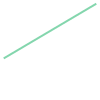

In [174]:
# 28 - dual carriagway neighbouring with single and dual carriagway
# 33 - dual carriageway with reverse orientation than the neighbour
# 82 - <1m dual carriageway with adjacent single carriageways
# 247 - dual carriageway ending in intersections with only single carriageways
# 586
next(iter(roads_width_final_final[roads_width_final_final['gid'] == 28].apply(join_carriageways, axis=1)))

In [175]:
roads_width_final_final['length'].head()

0    52.421
1    17.053
2    11.104
3    12.955
4    42.491
Name: length, dtype: float64

In [178]:
roads_width_final_final['fixed_carriageways'] = roads_width_final_final.apply(join_carriageways, axis=1)

In [179]:
geopandas.GeoDataFrame(roads_width_final_final[['u', 'v', 'fixed_carriageways']], geometry='fixed_carriageways', crs='EPSG:28992').to_file('output/fixed_carriageways.geojson', driver='GeoJSON')

1. Smooth out the carriageways between them:
    - Normal case (two double-carriageways meet), we compute the mid point of the endpoints and join the lines.
    - When a double-carriageway meets a single one, we join with a triangle.
2. Find outliers that are too wide and are a dead-end.
3. Compute the new nodes of the network.

# Introduce flyovers

# Validation and evaluation

- We need to rectify our conditions for outliers regarding our decision of carriageway number from width.
- **INVESTIGATION REQUIRED**: If <1m segment is dual carriageway and neighbouring to both a single and a dual carriageway then we should make sure the methodology works.
- Ensure completeless of network (run a simple routing problem)
- Compute decorations like traffic lights
- Potentionally compute more interesting algorithms, e.g. what the best route about de-icing given the width of street (exploiting the semantic surfaces here).